We are going to look at the overlap integral between two beams to find the transmitted power.

This proceeds as follows:
    - define a 2D spatial grid of extent^2 EXTENT = 10mm
    - define the modes of interest on this grid as functions returning the E field
        - Generally a Gaussian function  which takes the two waists and returns the E grid
    - We want a gaussian w=1875um and an ellipse w=1000um and 1200um
    - a fuction to find the transmission, which performs the normalised overlap integral between the modes provided

In [1]:
# Define SI unit prefixes
nm = nHz = nA = nV = nW = 1e-9
um = uHz = uA = uV = uW = 1e-6
mm = mHz = mA = mV = mW = 1e-3
cm = 1e2
Hz = A = V = W = 1
kHz = kA = kV = kW = 1e3
MHz = MA = MV = MW = 1e6
GHz = GA = GV = GW = 1e9

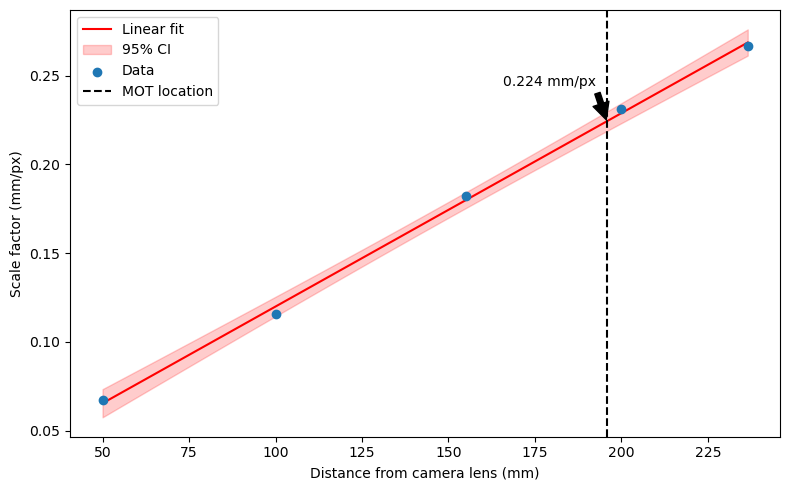

slope (95% CI): 0.001090 ± 0.000067
intercept (95% CI): 0.010917 ± 0.010854


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import t

# Data
x = np.array([50, 100, 155, 200, 236.5])
y = np.array([0.067, 0.116, 0.182, 0.231, 0.267])
n = len(x)
dof = n - 2  # degrees of freedom

# Fit linear regression
result = stats.linregress(x, y)
slope = result.slope
intercept = result.intercept

# Predicted values
x_fit = np.linspace(min(x), max(x), 200)
y_fit = result.intercept + result.slope * x_fit

# Calculate standard error of regression
y_pred = result.intercept + result.slope * x
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / dof)

# Confidence interval bounds
t_val = t.ppf(1 - 0.025, dof)  # 95% CI
mean_x = np.mean(x)
conf_interval = (
    t_val * s_err * np.sqrt(1 / n + (x_fit - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
)

# Upper and lower bounds
y_upper = y_fit + conf_interval
y_lower = y_fit - conf_interval

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_fit, y_fit, "r-", label="Linear fit")
plt.fill_between(x_fit, y_lower, y_upper, color="r", alpha=0.2, label="95% CI")
plt.scatter(x, y, label="Data", zorder=5)
plt.xlabel("Distance from camera lens (mm)")
plt.ylabel("Scale factor (mm/px)")

# Annotate MOT location
MOT_location = (155 + 236.5) / 2 # middle of the coils
MOT_location_err = 4 # estimated error
scale_factor = result.slope * MOT_location + result.intercept
plt.axvline(x=MOT_location, color="k", linestyle="--", label="MOT location")
plt.annotate(
    f"{scale_factor:.3f} mm/px",
    xy=(MOT_location, scale_factor),
    xytext=(MOT_location - 30, scale_factor + 0.02),
    arrowprops=dict(facecolor="black", shrink=0.05),
)

plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# fiber coupling lens
import numpy as np

wavelength = 780.24*nm # Rb87

# mode_field_diameter = 5.3*um # Thorlabs P3-780PM-FC-* fiber
mfd_variation = 1.0 * um  # Thorlabs P3-780PM-FC-* fiber
mode_field_diameter = 4.0 * um  # Jenoptik EOM bowtie
mfd_variation = 0.5 * um  # estimated as not quoted - Jenoptik EOM bowtie

input_diameter = 2.0 * mm  # input collimated beam diameter - 1/e^2
id_variation = 0.25 * mm

min_focal_length = np.pi * (input_diameter - id_variation) * (mode_field_diameter - mfd_variation) / (4 * wavelength)
focal_length = np.pi * input_diameter * mode_field_diameter / (4 * wavelength)
max_focal_length = np.pi * (input_diameter + id_variation) * (mode_field_diameter + mfd_variation) / (4 * wavelength)

print(f"Focal length = {focal_length/mm:.2f} mm\nvariation = {min_focal_length/mm:.2f} mm -> {max_focal_length/mm:.2f} mm")

Focal length = 8.05 mm
variation = 6.17 mm -> 10.19 mm


In [1]:
import numpy as np
import matplotlib.pyplot as plt

REALISTIC_LOSSES = 0.95

# Constants
PI = np.pi
CM = 1e-2
UM = 1e-6
NM = 1e-9

EXTENT = 0.5*CM
SIZE = 2**13

In [2]:
def gaussian2D(x: np.ndarray, y: np.ndarray, w: float, wy: float = None, angle: float = 0.0 * np.pi):
    """
    Returns the E field of a 2D gaussian evaluated over the grid defined by x,y

    REQUIRED
        x,y - np.meshgrid arrays
        w - Waist of the gaussian in the x direction

    OPTIONAL
        wy - Waist of the gaussian in the y direction
        angle - Clockwise rotation of the gaussian in the x,y plane
    
    This can be elliptical along any axis, we perform a rotation on the x,y grid to achieve this
    """
    if wy is None:  # if wy is not specified, assume circular
        wy = w

    vals = np.exp(-((x*np.cos(angle) - y*np.sin(angle))**2/(w**2) + (x*np.sin(angle) + y*np.cos(angle))**2/(wy**2)))
    # normalise |vals|^2 = 1
    return vals / np.sqrt(np.sum(vals**2))

def overlap_integral(mode1: np.ndarray, mode2: np.ndarray, x: np.ndarray = None, y: np.ndarray = None):
    """
    Returns the overlap integral of two modes, mode1 and mode2, over the grid defined by x,y
    """
    return np.sum(mode1 * mode2.conj())

def mode_power_transmission(mode1: np.ndarray, mode2: np.ndarray, x: np.ndarray = None, y: np.ndarray = None):
    """
    Returns the power transmission of mode1 through mode2
    """
    return np.abs(overlap_integral(mode1, mode2, x, y))**2


In [5]:

x = np.linspace(-EXTENT, EXTENT, SIZE)
y = np.linspace(-EXTENT, EXTENT, SIZE)
X, Y = np.meshgrid(x, y)

fiber_mode = gaussian2D(X, Y, 1875 * UM)
laser_mode = gaussian2D(X, Y, 1620 * UM, 2364 * UM)


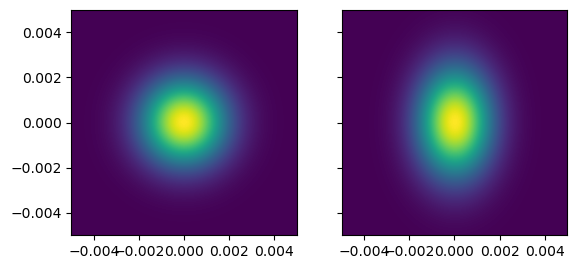

Transmission: 0.96
Realistic transmission is around 0.92


In [6]:
# plot the two modes side by side
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].imshow(np.abs(fiber_mode), extent=[-EXTENT, EXTENT, -EXTENT, EXTENT])
ax[1].imshow(np.abs(laser_mode), extent=[-EXTENT, EXTENT, -EXTENT, EXTENT])

plt.show()

# calculate the transmission of the laser mode through the fiber mode
transmission = mode_power_transmission(fiber_mode, laser_mode, x, y)
print(
    f"Transmission: {transmission:.2f}\nRealistic transmission is around {REALISTIC_LOSSES*transmission:.2f}"
)